In [3]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import missingno

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

In [4]:
# Data Load
data = pd.read_csv("ch3_premium.csv")

In [6]:
# 1. 문제가 무엇인가? 보험사 고객 정보를 통해 보험료 예측 모델을 생성
# Data 모양 확인
print(data.shape)

(1338, 7)


In [7]:
print(data.head(15))

    age     sex     bmi  children smoker     region      charges
0    19  female  27.900         0    yes  southwest  16884.92400
1    18    male  33.770         1     no  southeast   1725.55230
2    28    male  33.000         3     no  southeast   4449.46200
3    33    male  22.705         0     no  northwest  21984.47061
4    32    male  28.880         0     no  northwest   3866.85520
5    31  female  25.740         0     no  southeast   3756.62160
6    46  female  33.440         1     no  southeast   8240.58960
7    37  female  27.740         3     no  northwest   7281.50560
8    37    male  29.830         2     no  northeast   6406.41070
9    60  female  25.840         0     no  northwest  28923.13692
10   25    male  26.220         0     no  northeast   2721.32080
11   62  female  26.290         0    yes  southeast  27808.72510
12   23    male  34.400         0     no  southwest   1826.84300
13   56  female  39.820         0     no  southeast  11090.71780
14   27    male     NaN  

In [12]:
# 2. 중복된 항목은 있는가?
# 중복된 항목 수
print("중복된 항목 수 :", len(data[data.duplicated()]))

중복된 항목 수 : 1


In [14]:
# 중복된 항목 확인
print(data[data.duplicated(keep=False)].sort_values(by=list(data.columns)).head())

     age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631


In [15]:
# 중복된 항목 제거
data.drop_duplicates(inplace=True, keep='first', ignore_index=True)

In [16]:
data.shape

(1337, 7)

In [17]:
# 어떤 종류의 데이터가 있고 다른 타입의 데이터들을 어떻게 다룰 것 인가?
# 데이터 컬럼 이름, 타입 정보 확인
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1332 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB
None


In [21]:
# 데이터 타입별 컬럼 수 확인
dtype_data = data.dtypes.reset_index()
dtype_data.columns = ["Count", "Column Type"]
dtype_data = dtype_data.groupby("Column Type").aggregate('count').reset_index()

print(dtype_data)

  Column Type  Count
0       int64      2
1     float64      2
2      object      3


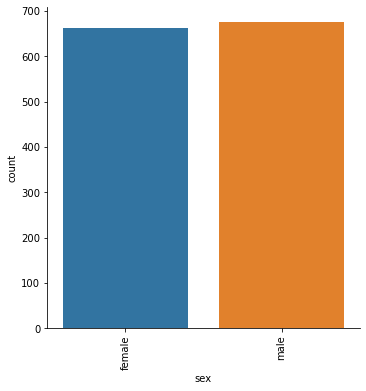

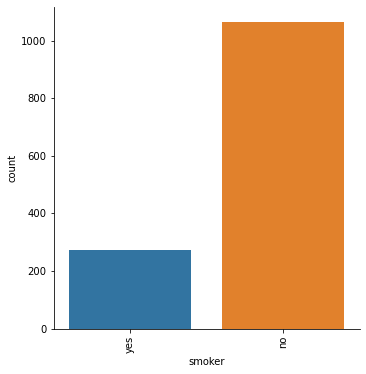

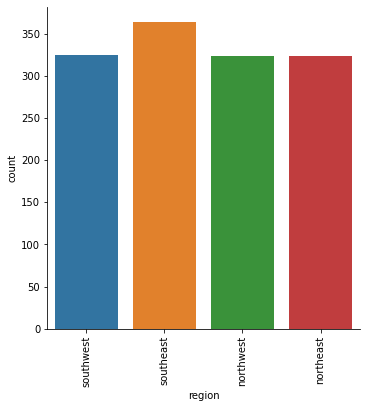

In [22]:
# 범주형 변수
# 범주형 변수 별 개수 시각화
for col in data.select_dtypes(include=['object','category']).columns:
    fig = sns.catplot(x=col, kind="count", data=data, hue=None)
    fig.set_xticklabels(rotation=90)
    plt.show()

In [23]:
# 데이터 컬럼별 유일한 값 개수 확인
print(data.select_dtypes(include=['object', 'category']).nunique())

sex       2
smoker    2
region    4
dtype: int64


In [24]:
# 항목이 2개인 성별과 흡연 여부는 Label Encoder, 지역은 One-hot Encoder
# Label Encoder : 각각의 범주를 서로 다른 정수로 맵핑
sex = data.iloc[:,1:2].values
smoker = data.iloc[:,4:5].values

# 성별을 LabelEncoder를 선언해주고 fit_transform에 넣어줌
le = LabelEncoder()
sex[:,0] = le.fit_transform(sex[:,0])
sex = pd.DataFrame(sex)
sex.columns = ['sex']
print(sex)

# dict 형으로 변환
le_sex_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("성별에 대한 Label Encoder 결과 : ")   
print(le_sex_mapping)
print(sex[:10])

     sex
0      0
1      1
2      1
3      1
4      1
...   ..
1332   1
1333   0
1334   0
1335   0
1336   0

[1337 rows x 1 columns]
성별에 대한 Label Encoder 결과 : 
{'female': 0, 'male': 1}
  sex
0   0
1   1
2   1
3   1
4   1
5   0
6   0
7   0
8   1
9   0


In [25]:
# 흡연 여부
# 위 과정과 동일
le = LabelEncoder()
smoker[:,0] = le.fit_transform(smoker[:,0])
smoker = pd.DataFrame(smoker)
smoker.columns = ['smoker']
print(smoker)

le_smoker_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("흡연 여부에 대한 Label Encoder 결과 : ")    
print(le_smoker_mapping)
print(smoker[:10])

     smoker
0         1
1         0
2         0
3         0
4         0
...     ...
1332      0
1333      0
1334      0
1335      0
1336      1

[1337 rows x 1 columns]
흡연 여부에 대한 Label Encoder 결과 : 
{'no': 0, 'yes': 1}
  smoker
0      1
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0


In [28]:
# One-hot Encoder : 각각의 범주를 0과 1로 맵핑
# 지역 컬럼은 Label Encoding을 위해 ndarray로 변환
region = data.iloc[:,5:6].values

ohe = OneHotEncoder()
region = ohe.fit_transform(region).toarray()
region = pd.DataFrame(region)
region.columns = ['northeast', 'northwest', 'southeast', 'southwest']
print("지역에 대한 OneHot Encoder 결과 : ")  
print(region[:10])

지역에 대한 OneHot Encoder 결과 : 
   northeast  northwest  southeast  southwest
0        0.0        0.0        0.0        1.0
1        0.0        0.0        1.0        0.0
2        0.0        0.0        1.0        0.0
3        0.0        1.0        0.0        0.0
4        0.0        1.0        0.0        0.0
5        0.0        0.0        1.0        0.0
6        0.0        0.0        1.0        0.0
7        0.0        1.0        0.0        0.0
8        1.0        0.0        0.0        0.0
9        0.0        1.0        0.0        0.0


bmi    5
dtype: int64


<AxesSubplot:>

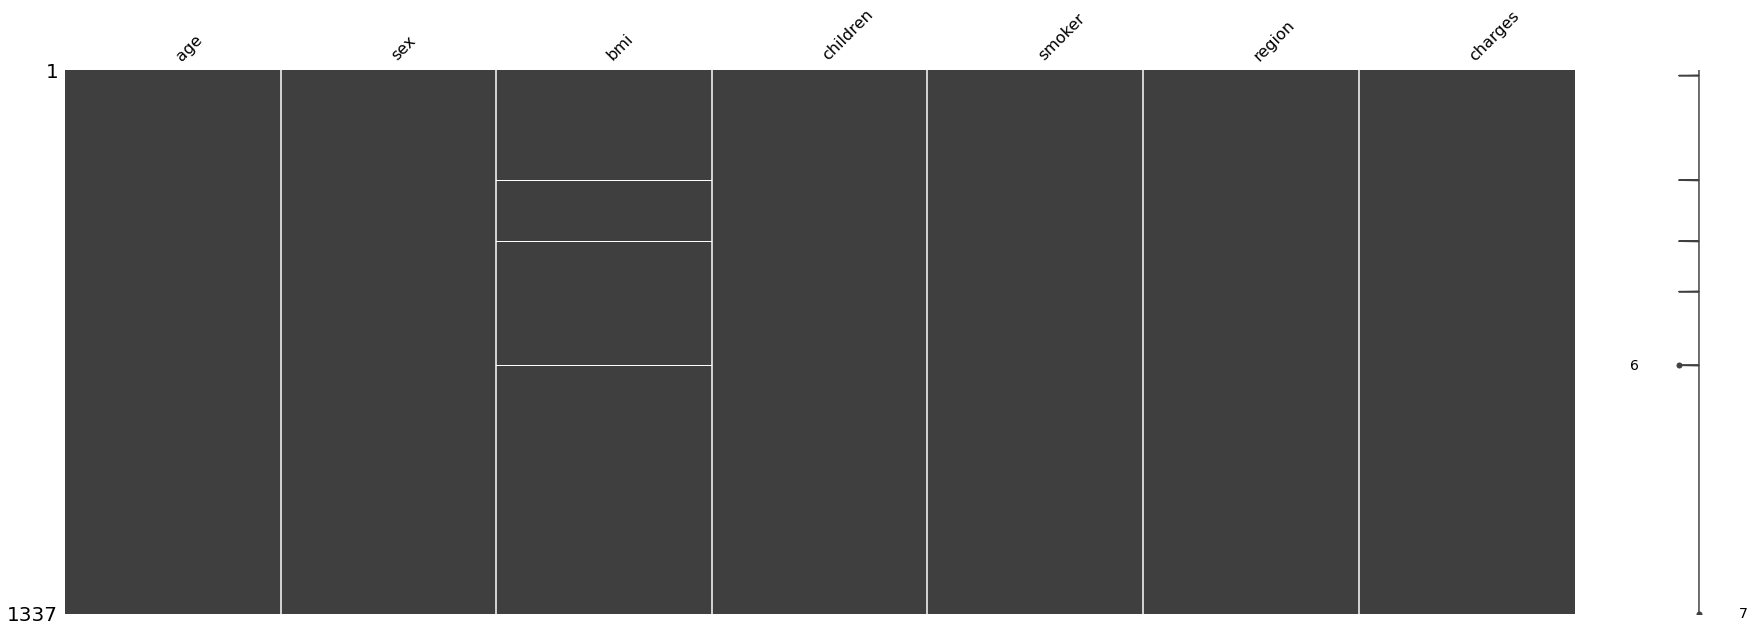

In [29]:
# 결측치가 있는지 확인하고 처리

# 각 컬럼들에 몇 개의 NULL 값이 포함되어 있는지 확인
count_nan = data.isnull().sum()
print(count_nan[count_nan > 0])

# missingno 패키지를 통해 시각화 확인
missingno.matrix(data, figsize = (30,10))

<AxesSubplot:>

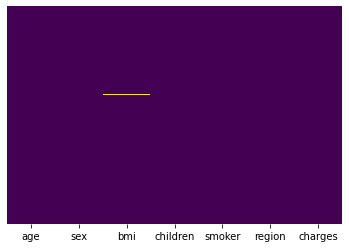

In [30]:
# heatmap을 통해 시각화
sns.heatmap(data.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

    age     sex        bmi  children smoker     region      charges
0    19  female  27.900000         0    yes  southwest  16884.92400
1    18    male  33.770000         1     no  southeast   1725.55230
2    28    male  33.000000         3     no  southeast   4449.46200
3    33    male  22.705000         0     no  northwest  21984.47061
4    32    male  28.880000         0     no  northwest   3866.85520
5    31  female  25.740000         0     no  southeast   3756.62160
6    46  female  33.440000         1     no  southeast   8240.58960
7    37  female  27.740000         3     no  northwest   7281.50560
8    37    male  29.830000         2     no  northeast   6406.41070
9    60  female  25.840000         0     no  northwest  28923.13692
10   25    male  26.220000         0     no  northeast   2721.32080
11   62  female  26.290000         0    yes  southeast  27808.72510
12   23    male  34.400000         0     no  southwest   1826.84300
13   56  female  39.820000         0     no  sou

<AxesSubplot:>

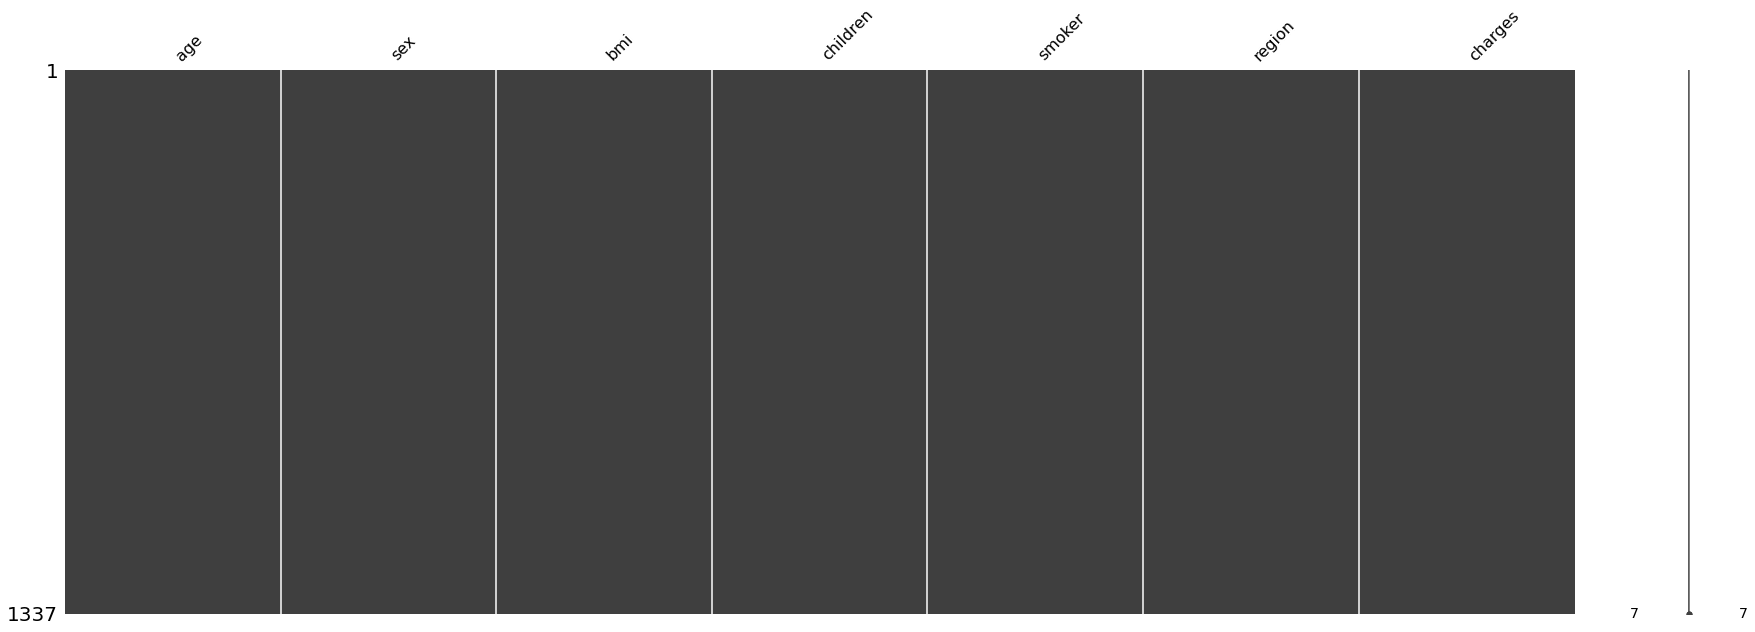

In [31]:
# NULL 값을 해당 컬럼의 평균값으로 대체하기
data['bmi'].fillna(data['bmi'].mean(), inplace = True)
print(data.head(15))

# 확인
count_nan = data.isnull().sum()
print(count_nan[count_nan > 0])

# missingno 패키지를 통해 시각화 재확인
missingno.matrix(data, figsize = (30,10))

In [32]:
# 이상치 확인하고 처리할 지 고려

# 데이터 컬럼별 요약 통계값
display(data.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.658596,6.083657,15.9600,26.315,30.4000,34.60000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


<AxesSubplot:ylabel='Frequency'>

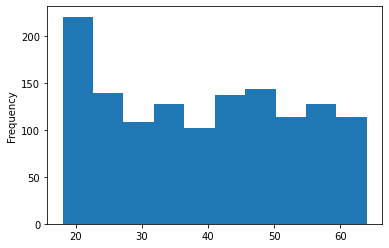

In [33]:
# 데이터 개별 컬럼 히스토그램으로 확인
data.age.plot.hist()

In [34]:
import scipy
scipy.__version__

'1.6.2'

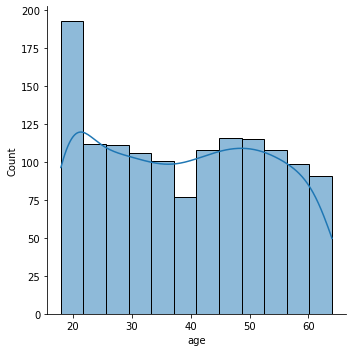

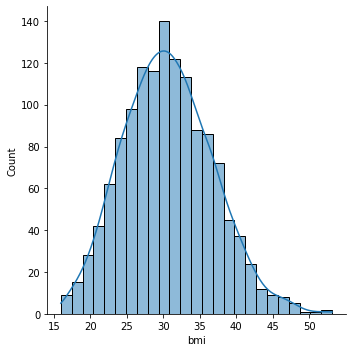

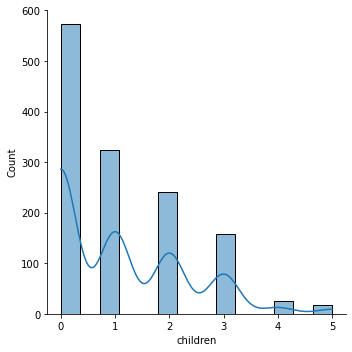

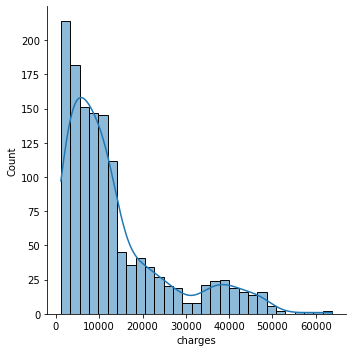

In [35]:
# 숫자형 데이터 Skewness 확인

# 데이터 컬럼 타입이 np.number 인 것만 가져오기
numeric_data = data.select_dtypes(include=np.number)

# 데이터 컬럼 타입이 np.number 인 컬럼 이름들 가져오기
l = numeric_data.columns.values
number_of_columns=4
number_of_rows = len(l)-1/number_of_columns


# 컬럼별 히스토그램 그리기

# plt.figure(figsize=(20,20))
for i in range(0,len(l)):
    # plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.displot(numeric_data[l[i]],kde=True) # kde : kernel density

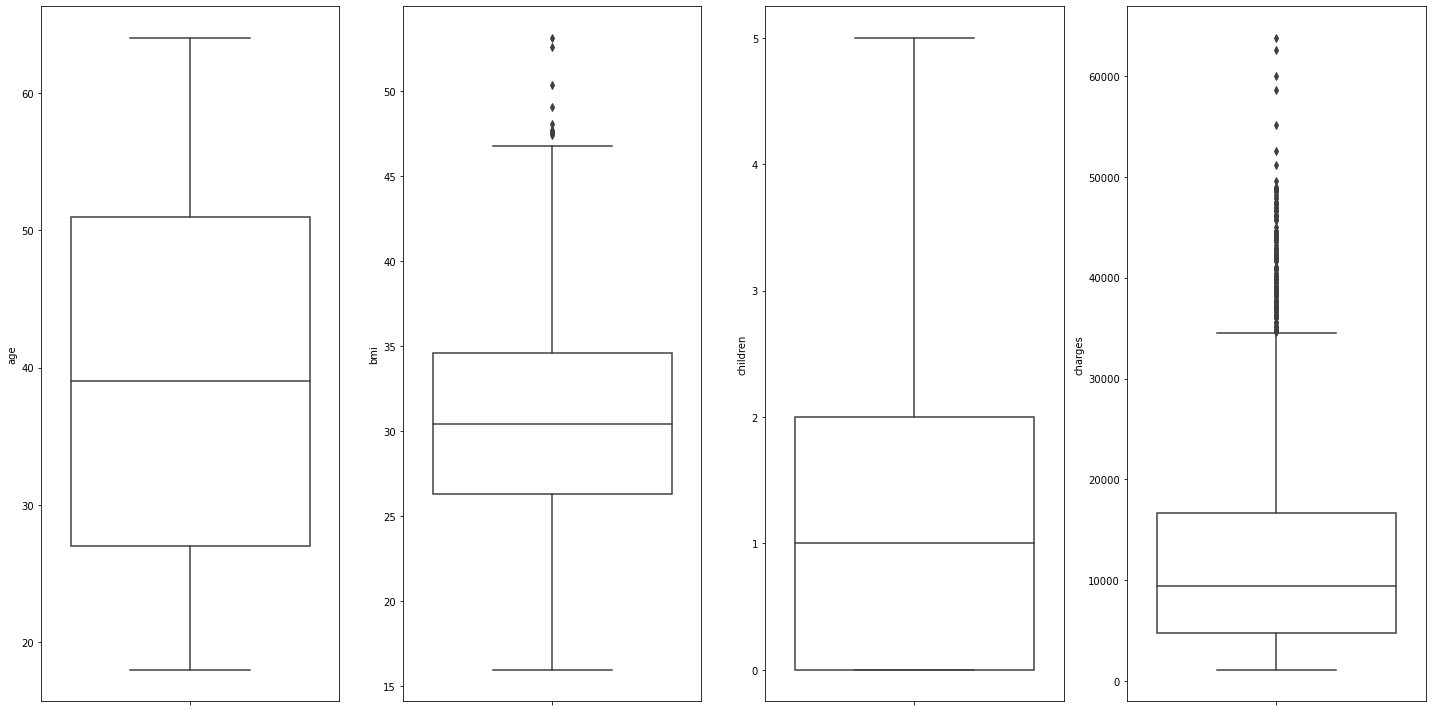

In [36]:
# 숫자형 데이터 Boxplot 시각화

# 데이터 컬럼 타입이 np.number 인 컬럼들 가져오기
columns = data.select_dtypes(include=np.number).columns
figure = plt.figure(figsize=(20, 10))
figure.add_subplot(1, len(columns), 1)
for index, col in enumerate(columns):
    if index > 0:
        figure.add_subplot(1, len(columns), index + 1)
    sns.boxplot(y=col, data=data, boxprops={'facecolor': 'None'})
figure.tight_layout() # 자동으로 명시된 여백에 관련된 서브플롯 파라미터를 조정한다.
plt.show()

<ipython-input-37-b92d980b192b>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(number_of_rows + 1,number_of_columns,i+1)
C:\Users\sclab\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\sclab\anaconda3\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
<ipython-input-37-b92d980b192b>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(number_of_rows + 1,num

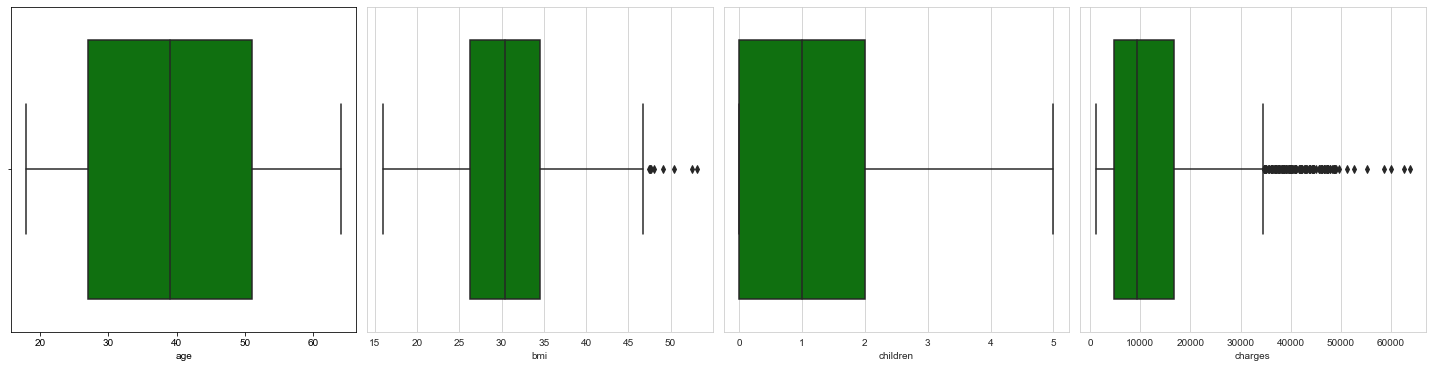

In [37]:

plt.figure(figsize=(20,20))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(numeric_data[l[i]],color='green',orient='v')
    plt.tight_layout()

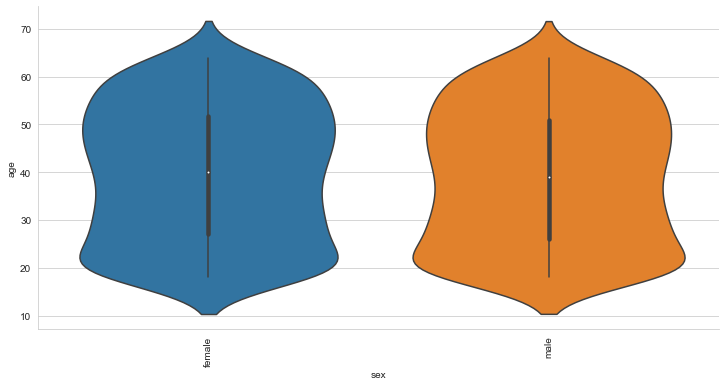

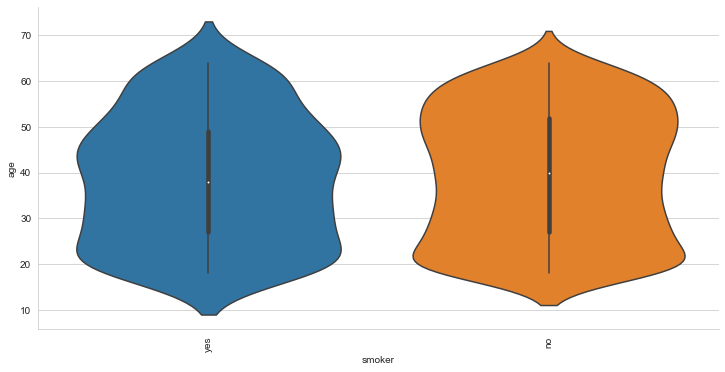

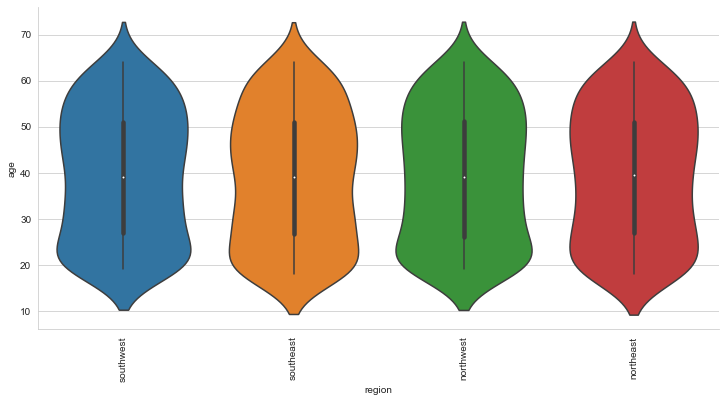

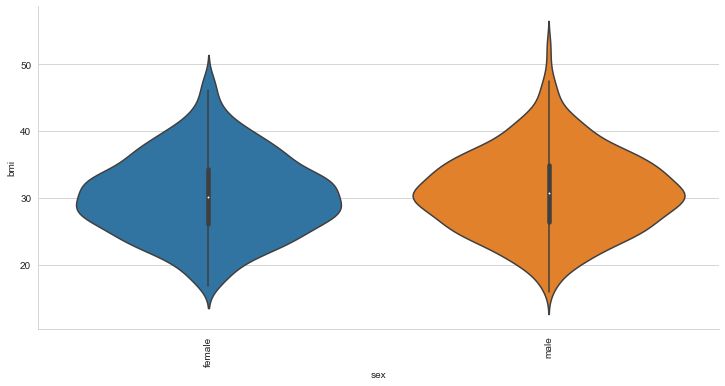

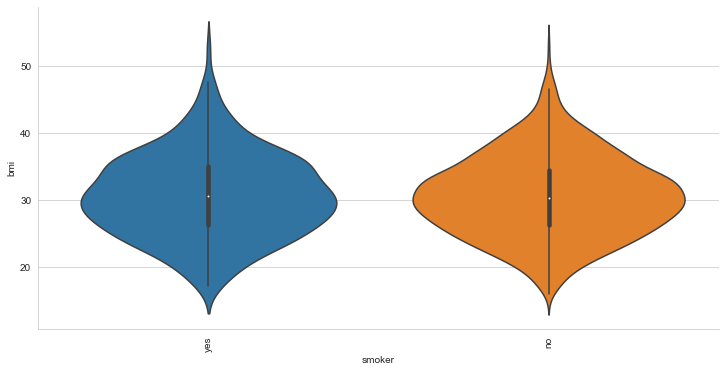

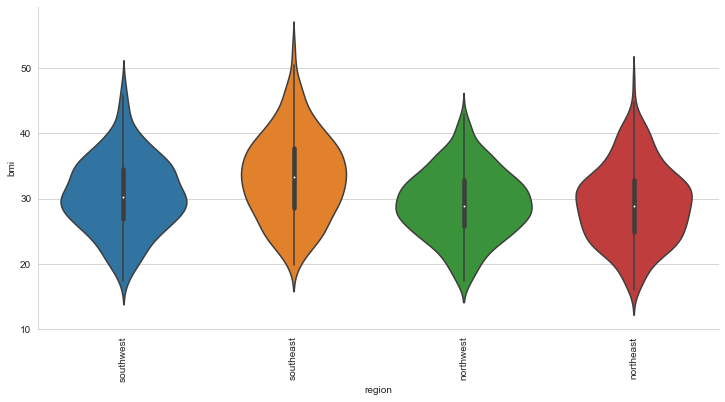

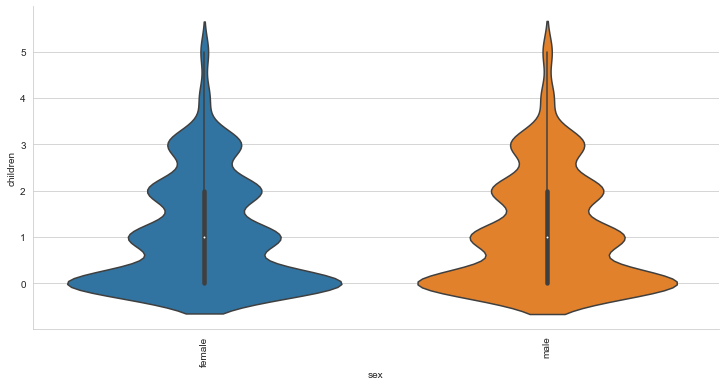

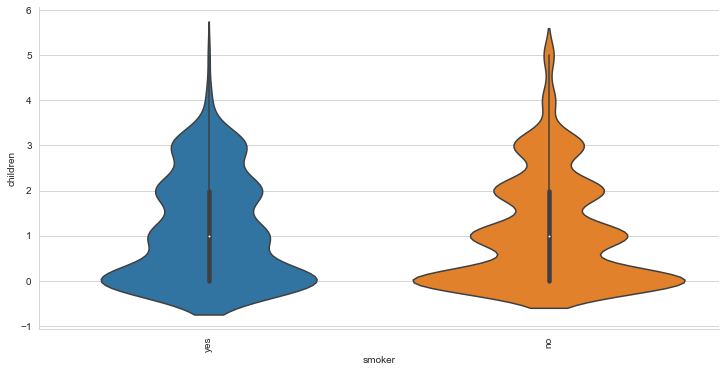

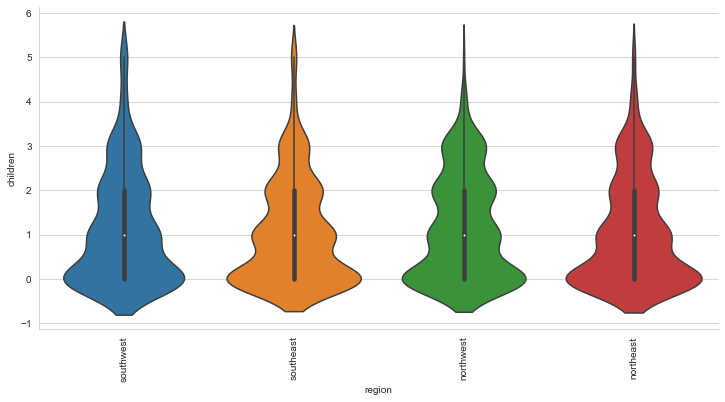

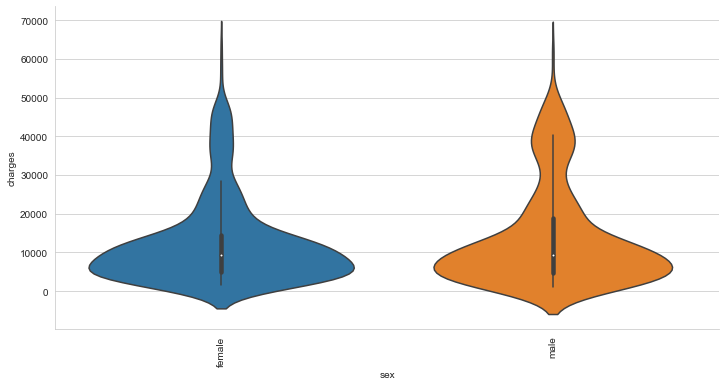

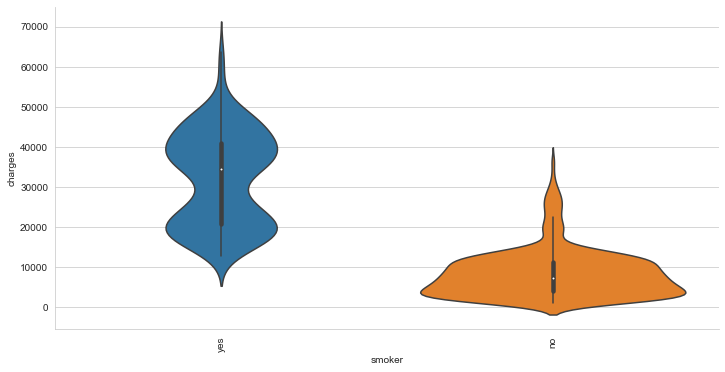

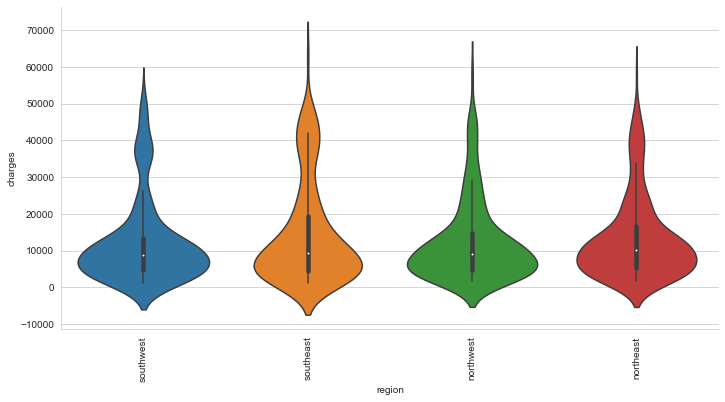

In [38]:
# 범주형 데이터 별 Violin plot 시각화
if len(data.select_dtypes(include=['object','category']).columns) > 0:
        for col_num in data.select_dtypes(include=np.number).columns:
            for col in data.select_dtypes(include=['object','category']).columns:
                fig = sns.catplot(x=col, y=col_num, kind='violin', data=data, height=5, aspect=2)
                fig.set_xticklabels(rotation=90)
                plt.show()

<AxesSubplot:>

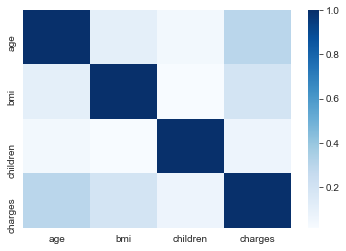

In [39]:
# 변수 간 상관성 확인

# 숫자형 데이터 간 Pairwise 결합 분포 시각화
# Heatmap을 사용한 Correlation 시각화
plt.figure(figsize=(6,4))
sns.heatmap(data.corr(),cmap='Blues',annot=False) 

<AxesSubplot:>

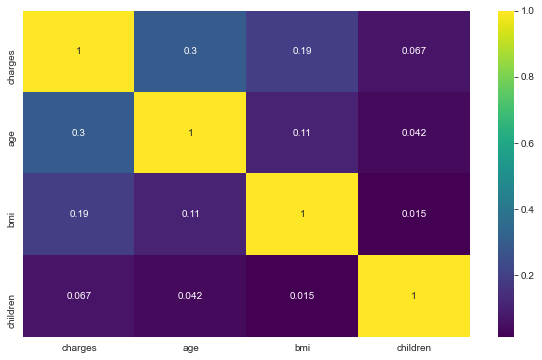

In [40]:
# 보험료 Correlation Matrix 시각화
k = 4 # Heatmap 에서 확인한 변수 개수
cols = data.corr().nlargest(k, 'charges')['charges'].index
cm = data[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

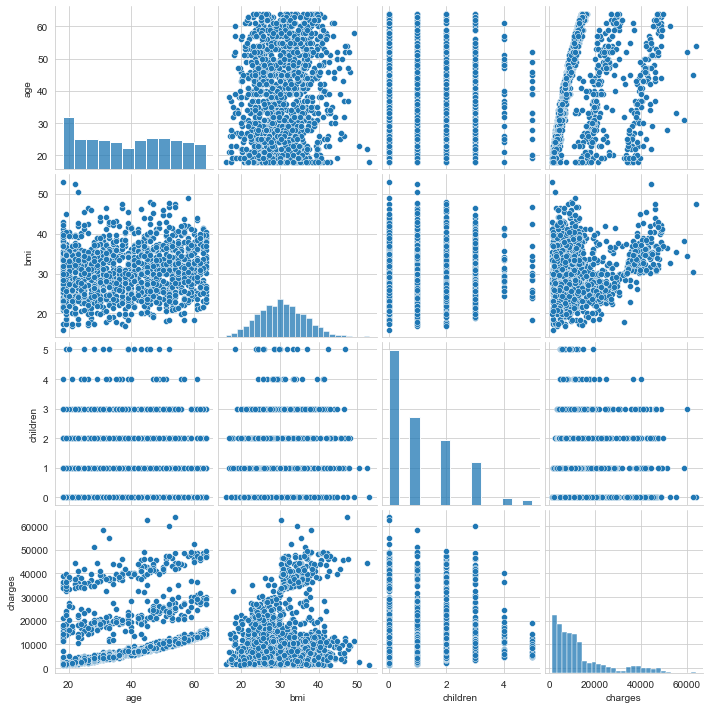

In [41]:
# 숫자 변수형 컬럼들 간 Pairplot 그리기
sns.pairplot(data.select_dtypes(include=np.number))
plt.show()

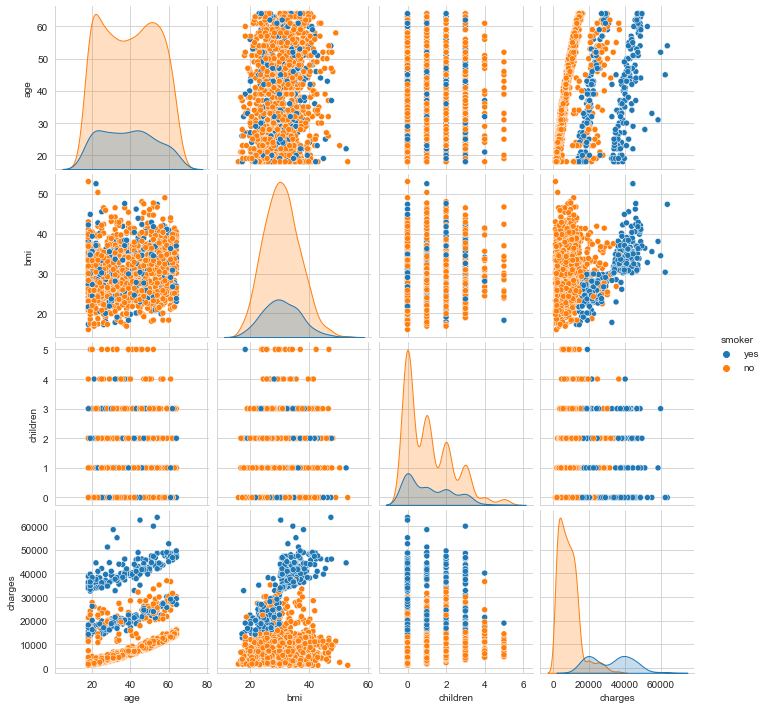

In [42]:
# 범주형 데이터를 기준으로 추가한 시각화
hue = 'smoker'
sns.pairplot(data.select_dtypes(include=np.number).join(data[[hue]]), hue=hue)
plt.show()

In [43]:
# 다양한 Regression을 활용한 보험료 예측

# Data Split

# 숫자형 데이터들만 copy() 를 사용하여 복사
X_num = data[['age', 'bmi', 'children']].copy()

# 변환했던 범주형 데이터들과 concat 을 사용하여 합치기
X_final = pd.concat([X_num, region, sex, smoker], axis = 1)

# 보험료 컬럼(charges)을 y 값으로 설정
y_final = data[['charges']].copy()

# train_test_split 을 사용하여 Training, Test 나누기 (Training:Test=2:1)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0)

In [44]:
X_train[0:10]

,age,bmi,children,northeast,northwest,southeast,southwest,sex,smoker
905,27,32.585,3,1.0,0.0,0.0,0.0,1,0
2,28,33.000,3,0.0,0.0,1.0,0.0,1,0
405,52,38.380,2,1.0,0.0,0.0,0.0,0,0
481,49,37.510,2,0.0,0.0,1.0,0.0,1,0
338,50,32.300,1,1.0,0.0,0.0,0.0,1,1
356,46,43.890,3,0.0,0.0,1.0,0.0,1,0
1258,52,23.180,0,1.0,0.0,0.0,0.0,0,0
182,22,19.950,3,1.0,0.0,0.0,0.0,1,0
461,42,30.000,0,0.0,0.0,0.0,1.0,1,1
1058,32,33.820,1,0.0,1.0,0.0,0.0,1,0


In [45]:
X_test[0:10]

,age,bmi,children,northeast,northwest,southeast,southwest,sex,smoker
1247,18,39.820,0,0.0,0.0,1.0,0.0,0,0
609,47,29.370,1,0.0,0.0,1.0,0.0,0,0
393,49,31.350,1,1.0,0.0,0.0,0.0,1,0
503,19,30.250,0,0.0,0.0,1.0,0.0,1,1
198,51,18.050,0,0.0,1.0,0.0,0.0,0,0
820,26,17.670,0,0.0,1.0,0.0,0.0,1,0
31,18,26.315,0,1.0,0.0,0.0,0.0,0,0
1250,19,19.800,0,0.0,0.0,0.0,1.0,1,0
1298,19,25.745,1,0.0,1.0,0.0,0.0,0,0
1150,58,36.480,0,0.0,1.0,0.0,0.0,0,0


In [46]:
# Feature Scaling
# 다차원의 값들을 비교 분석하기 쉬움
# 변수들 간의 단위 차이가 있을 때 필요
# Overflow, Underflow 방지


# MinMaxScaler를 사용하는 경우 : 이상치가 있는 경우 변환된 값이 매우 좁은 범위로 압축
# n_scaler = MinMaxScaler()
# X_train = n_scaler.fit_transform(X_train.astype(np.float))
# X_test= n_scaler.transform(X_test.astype(np.float))

# StandardScaler를 사용하는 경우 : 이상치가 있는 경우에는 균형 잡힌 결과를 보장하기 힘듦
s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test= s_scaler.transform(X_test.astype(np.float))

# 그 외 - RobustScaler를 사용하는 경우 : 이상치의 영향을 최소화한 기법. 중앙값과 IQR을 사용하기 때문에 표준화 후 동일한 값을 더 넓게 분포

<ipython-input-46-9d246b85b80a>:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = s_scaler.fit_transform(X_train.astype(np.float))
<ipython-input-46-9d246b85b80a>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test= s_scaler.transform(X_test.astype(np.float))


In [47]:
# Linear Regression

# 학습
lr = LinearRegression().fit(X_train,y_train)

# 예측
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# 평가
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print('lr train score %.3f, lr test score: %.3f' % (
lr.score(X_train,y_train),
lr.score(X_test, y_test)))

lr.coef_: [[3366.47112808 1725.71174012  603.99554217  268.25231121   14.31590009
   -13.39447522 -261.68008702  -71.08965939 9503.10176814]]
lr.intercept_: [13098.07379314]
lr train score 0.743, lr test score: 0.758


In [48]:
# Polynomial Regression

poly = PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(X_final)

X_train,X_test,y_train,y_test = train_test_split(X_poly,y_final, test_size = 0.33, random_state = 0)

# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

# 학습
poly_lr = LinearRegression().fit(X_train,y_train)

# 예측
y_train_pred = poly_lr.predict(X_train)
y_test_pred = poly_lr.predict(X_test)

# 평가
print('poly train score %.3f, poly test score: %.3f' % (
poly_lr.score(X_train,y_train),
poly_lr.score(X_test, y_test)))

poly train score 0.849, poly test score: 0.843


<ipython-input-48-3e5d3a5bdb2c>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = sc.fit_transform(X_train.astype(np.float))
<ipython-input-48-3e5d3a5bdb2c>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test= sc.transform(X_test.astype(np.float))


In [49]:
# Support Vector Regression

svr = SVR(kernel='linear', C = 300)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0 )

# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

# 학습
svr = svr.fit(X_train,y_train.values.ravel())
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

# 평가
print('svr train score %.3f, svr test score: %.3f' % (
svr.score(X_train,y_train),
svr.score(X_test, y_test)))

svr train score 0.715, svr test score: 0.718


<ipython-input-49-5b70fc7c6fba>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = sc.fit_transform(X_train.astype(np.float))
<ipython-input-49-5b70fc7c6fba>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test= sc.transform(X_test.astype(np.float))


In [50]:
# Random Forest Regression
forest = RandomForestRegressor(n_estimators = 100,
                              criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0 )

# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

# 학습
forest.fit(X_train,y_train.values.ravel())
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# 평가
print('forest train score %.3f, forest test score: %.3f' % (
forest.score(X_train, y_train),
forest.score(X_test, y_test)))

forest train score 0.975, forest test score: 0.842


<ipython-input-50-4e32da4ed32d>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = sc.fit_transform(X_train.astype(np.float))
<ipython-input-50-4e32da4ed32d>:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test= sc.transform(X_test.astype(np.float))


In [51]:
# Decision Tree Regression

dt = DecisionTreeRegressor(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0 )

# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

# 학습
dt = dt.fit(X_train,y_train.values.ravel())
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

# 평가
print('dt train score %.3f, dt test score: %.3f' % (
dt.score(X_train,y_train),
dt.score(X_test, y_test)))

dt train score 0.999, dt test score: 0.701


<ipython-input-51-a7969ced61c8>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = sc.fit_transform(X_train.astype(np.float))
<ipython-input-51-a7969ced61c8>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test= sc.transform(X_test.astype(np.float))


In [52]:
# 비교

# 앞에서 만든 regressor 변수들과 라벨을 묶어서 하나의 리스트로 모으기
regressors = [(lr, 'Linear Regression'),
                (poly_lr, 'Polynomial Regression'),
                (svr, 'SupportVector Regression'),
                (forest, 'RandomForest Regression'),
                (dt, 'DecisionTree')]

# 각 regressor 변수들과 라벨 묶음을 차례로 학습 -> 예측 -> 평가 순으로 처리해서 보여주기
for reg, label in regressors:
    print(80*'_', '\n')
    reg = reg.fit(X_train,y_train.values.ravel())
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)
    print(f'{label} train score %.3f, {label} test score: %.3f' % (
    reg.score(X_train,y_train),
    reg.score(X_test, y_test)))

________________________________________________________________________________ 

Linear Regression train score 0.743, Linear Regression test score: 0.758
________________________________________________________________________________ 

Polynomial Regression train score 0.743, Polynomial Regression test score: 0.758
________________________________________________________________________________ 

SupportVector Regression train score 0.715, SupportVector Regression test score: 0.718
________________________________________________________________________________ 

RandomForest Regression train score 0.975, RandomForest Regression test score: 0.842
________________________________________________________________________________ 

DecisionTree train score 0.999, DecisionTree test score: 0.701
